# Chronos - Basic Usage

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
my_ts_data.shape

(2905, 2)

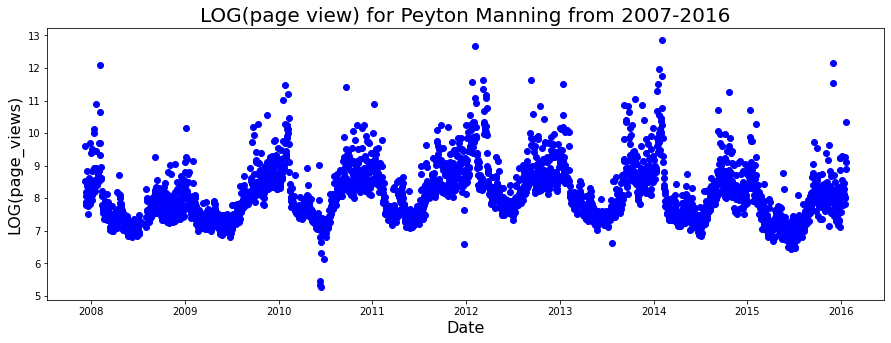

In [4]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

In [5]:
from chronos import Chronos

In [6]:
my_chronos = Chronos(method="MAP", max_iter=1000, learning_rate=0.1)
my_chronos.fit(my_ts_data)

Employing Maximum A Posteriori
100.0% - ELBO loss: 0.6526                                                                          


In [7]:
future_df = my_chronos.make_future_dataframe(period=365)
future_df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
3265,2017-01-15,NaN
3266,2017-01-16,NaN
3267,2017-01-17,NaN
3268,2017-01-18,NaN


In [8]:
predictions = my_chronos.predict(future_df, sample_number=1000)

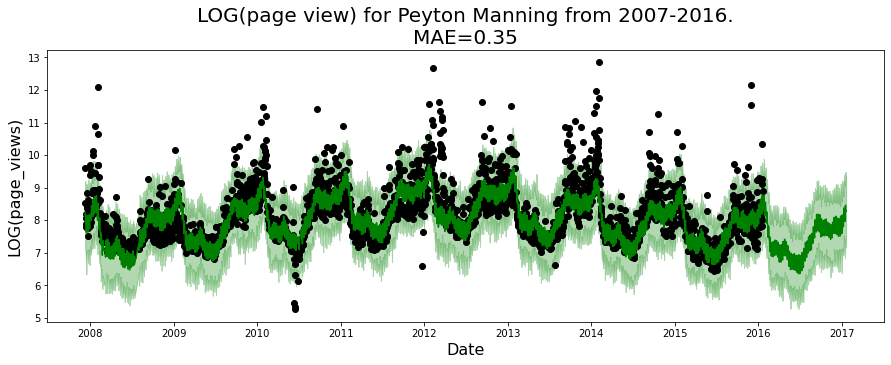

In [9]:
MAE = round(np.mean(np.abs(future_df['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], predictions['yhat'], c="green")
plt.fill_between(future_df['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(future_df['ds'], future_df['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016.\nMAE={MAE}", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

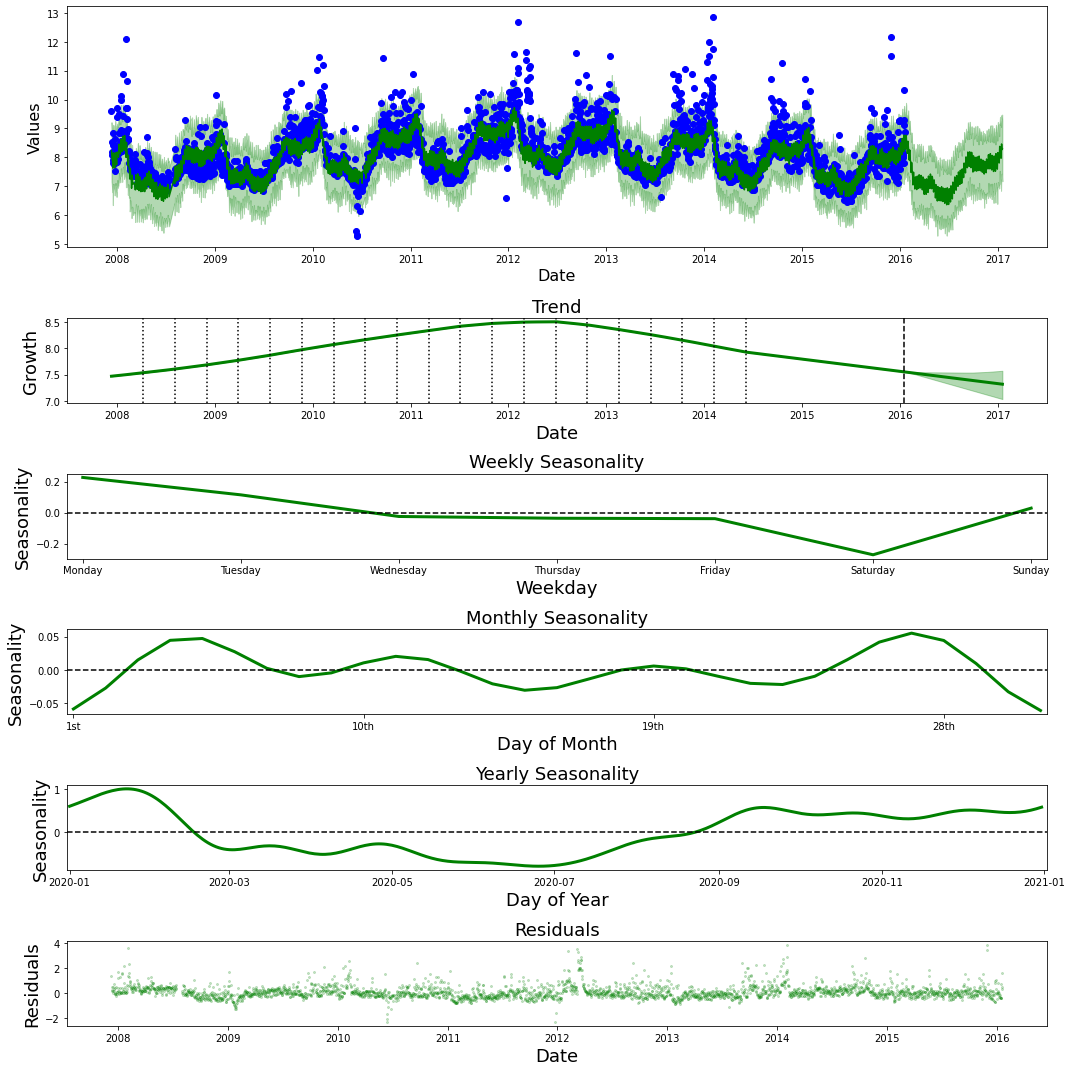

In [10]:
my_chronos.plot_components(predictions);

## COVID

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [12]:
covid_data = pd.read_csv('data/covid19-download.csv')
covid_data.head(2)

,pruid,prname,prnameFR,date,numconf,numprob,numdeaths,numtotal,numtested,numrecover,...,numdeaths_last14,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7
0,35,Ontario,Ontario,2020-01-31,3,0,0.0,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,British Columbia,Colombie-Britannique,2020-01-31,1,0,0.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
canada_mask = covid_data['prname'] == 'Canada'
desired_columns = ['date', 'numtoday']

canada_daily_covid = covid_data[desired_columns].loc[canada_mask]
canada_daily_covid.head()

,date,numtoday
2,2020-01-31,4
5,2020-02-08,3
8,2020-02-16,1
11,2020-02-21,1
14,2020-02-24,1


In [14]:
canada_daily_covid.rename({'date': 'ds', 'numtoday': 'y'}, axis=1, inplace=True)
canada_daily_covid['ds'] = pd.to_datetime(canada_daily_covid['ds'])
canada_daily_covid.head()

,ds,y
2,2020-01-31,4
5,2020-02-08,3
8,2020-02-16,1
11,2020-02-21,1
14,2020-02-24,1


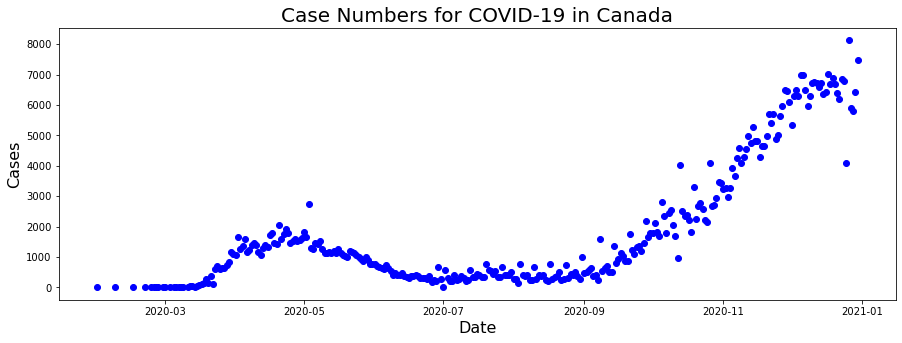

In [15]:
plt.figure(figsize=(15,5))
plt.scatter(canada_daily_covid['ds'], canada_daily_covid['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Cases", size=16)
plt.title(f"Case Numbers for COVID-19 in Canada", size=20)
plt.show()

In [16]:
my_chronos = Chronos(method="MAP", max_iter=1000, 
                     learning_rate=0.1, 
                     n_changepoints=25,
                     changepoint_range=0.95,
                     changepoint_prior=5.0,
                     year_seasonality_order=0)
my_chronos.fit(canada_daily_covid)

Employing Maximum A Posteriori
100.0% - ELBO loss: 7.7422                                                                          


In [17]:
future_df = my_chronos.make_future_dataframe(period=62, frequency='D')
future_df

,ds,y
0,2020-01-31,4.0
1,2020-02-08,3.0
2,2020-02-16,1.0
3,2020-02-21,1.0
4,2020-02-24,1.0
...,...,...
368,2021-02-26,NaN
369,2021-02-27,NaN
370,2021-02-28,NaN
371,2021-03-01,NaN


In [18]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

,y,ds,yhat,yhat_upper,yhat_lower,trend,trend_upper,trend_lower
0,4.0,2020-01-31,-6.792933,795.467590,-874.878479,-28.595564,-28.595247,-28.595247
1,3.0,2020-02-08,-29.391310,737.476196,-783.476929,-28.607533,-28.607731,-28.607731
2,1.0,2020-02-16,-44.849659,745.919800,-994.086609,-17.609375,-17.609375,-17.609375
3,1.0,2020-02-21,21.973747,894.013550,-700.165894,0.734375,0.734375,0.734375
4,1.0,2020-02-24,52.653393,820.027771,-587.430298,11.742188,11.742188,11.742188


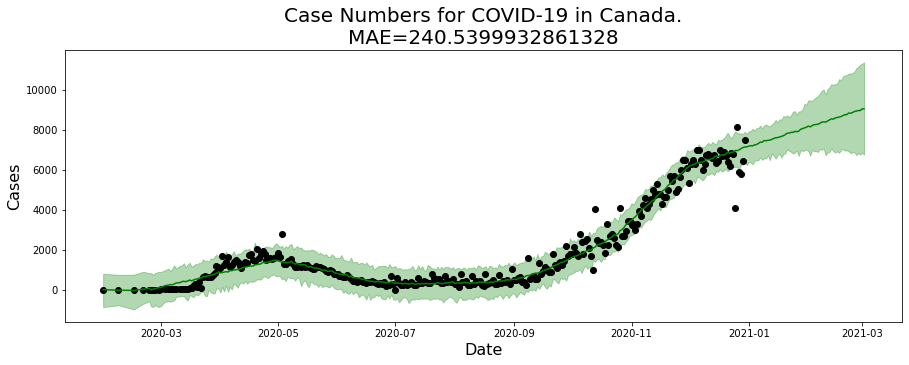

In [19]:
MAE = round(np.mean(np.abs(predictions['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(predictions['ds'], predictions['yhat'], c="green")
plt.fill_between(predictions['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(predictions['ds'], predictions['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("Cases", size=16)
plt.title(f"Case Numbers for COVID-19 in Canada.\nMAE={MAE}", size=20)
plt.show()

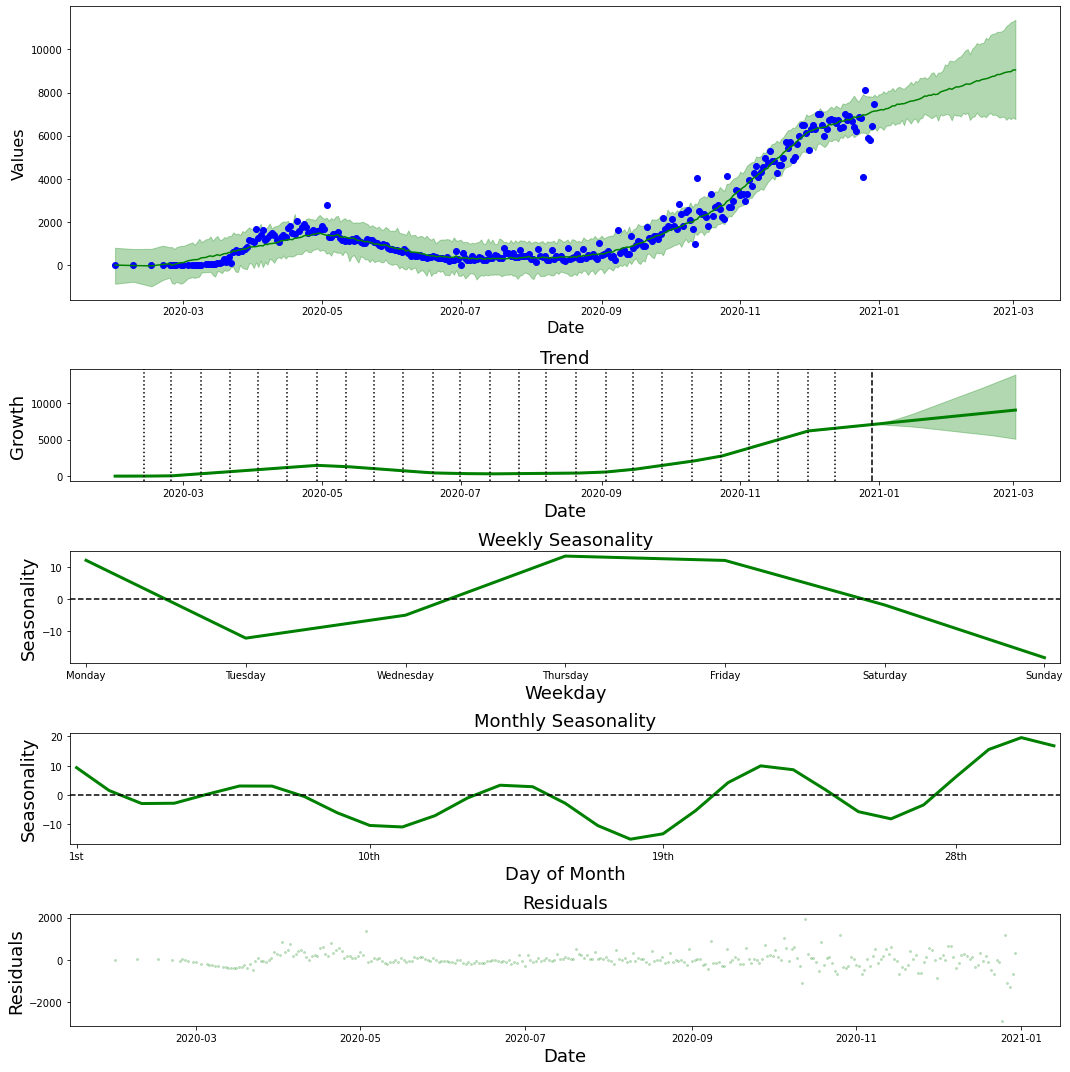

In [20]:
my_chronos.plot_components(predictions);

## AAPL stocks

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [22]:
my_ts_data = pd.read_csv('data/AAPL.csv')
my_ts_data = my_ts_data[['Date', 'Adj Close']]
my_ts_data.columns = ['ds', 'y']
#my_ts_data['y'] = 100*my_ts_data['y'].pct_change()
my_ts_data.dropna(inplace=True)
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2018-12-26,38.379425
1,2018-12-27,38.130344
2,2018-12-28,38.149883
3,2018-12-31,38.518612
4,2019-01-02,38.562561


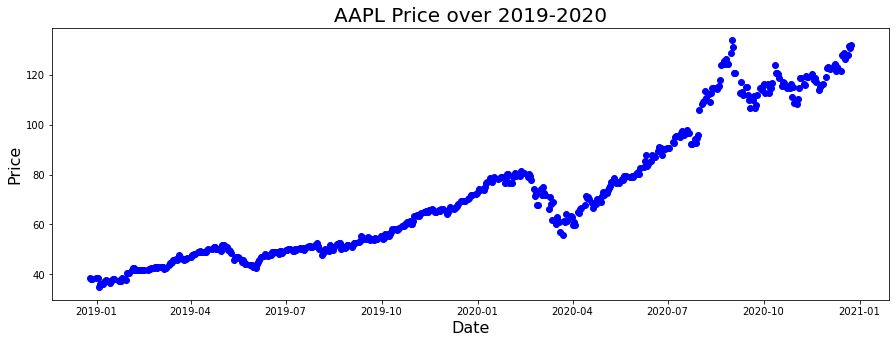

In [23]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020", size=20)
plt.show()

In [24]:
my_chronos = Chronos(method="MLE", max_iter=10000, 
                     learning_rate=0.1, 
                     n_changepoints=25,
                     year_seasonality_order=0)
my_chronos.fit(my_ts_data)

Employing Maximum Likelihood Estimation
100.0% - ELBO loss: 2.5073                                                                          


In [25]:
future_df = my_chronos.make_future_dataframe(period=62)
future_df

,ds,y
0,2018-12-26,38.379425
1,2018-12-27,38.130344
2,2018-12-28,38.149883
3,2018-12-31,38.518612
4,2019-01-02,38.562561
...,...,...
562,2021-02-20,NaN
563,2021-02-21,NaN
564,2021-02-22,NaN
565,2021-02-23,NaN


In [26]:
predictions = my_chronos.predict(future_df, sample_number=1000)

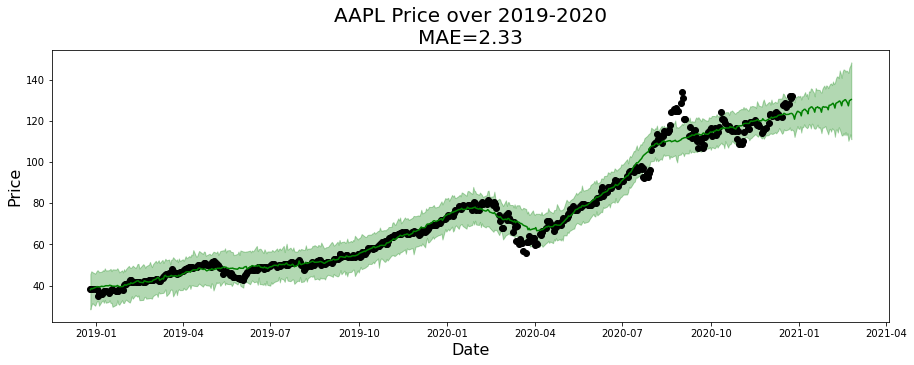

In [27]:
MAE = round(np.mean(np.abs(future_df['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], predictions['yhat'], c="green")
plt.fill_between(future_df['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(future_df['ds'], future_df['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020\nMAE={MAE}", size=20)
plt.show()

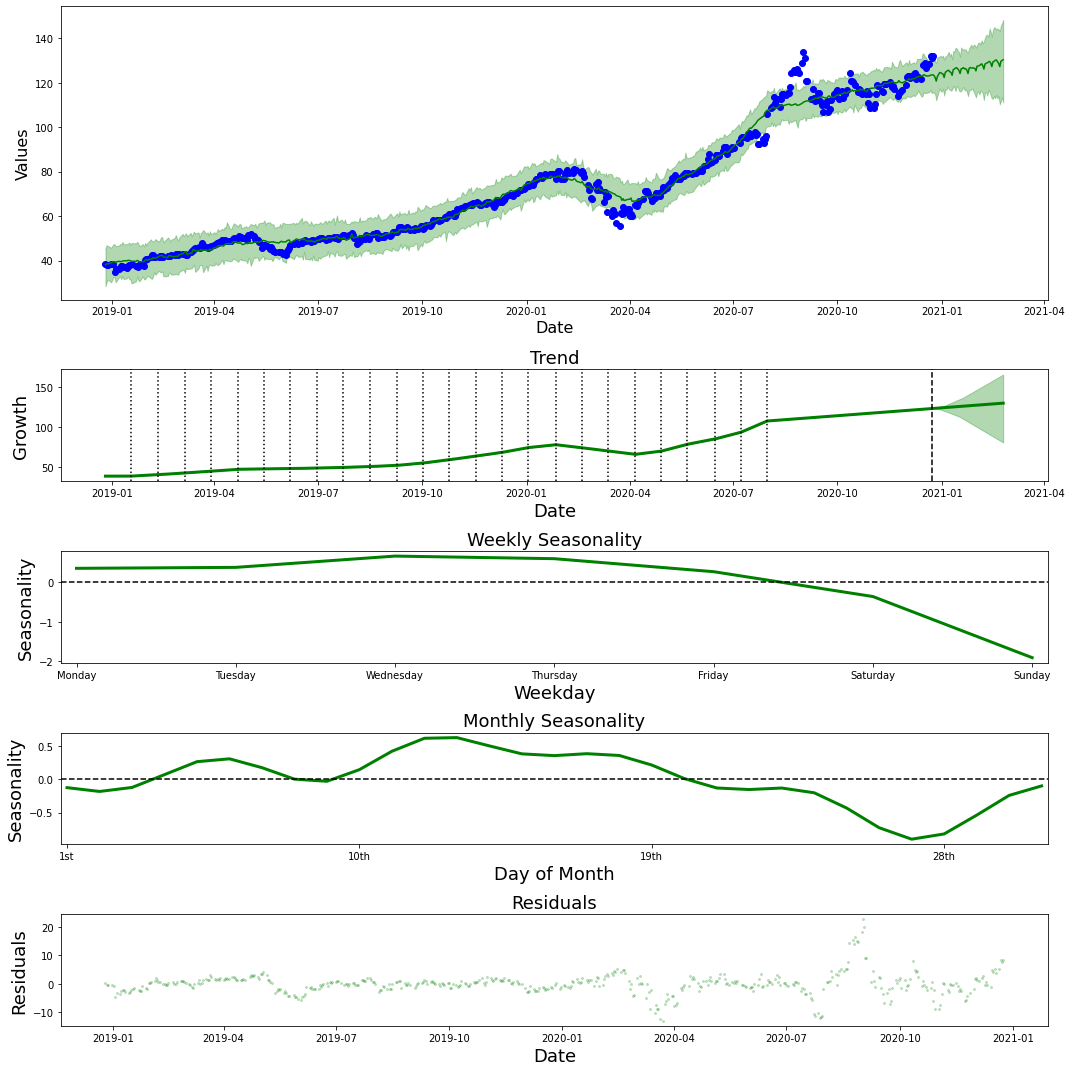

In [28]:
my_chronos.plot_components(predictions);